# Prompt Tuning for ESG Language Classification (ESG-Prospectus-Clarity-Category)

- [ 1 - Set up Kernel, Load Required Dependencies, Dataset and LLM](#1)
  - [ 1.1 - Set up Required Dependencies and Imports](#1.1)
  - [ 1.2 - Load LLM - Facebook OPT 1.3B Model](#1.2)
  - [ 1.3 - Load ESG-Prospectus-Clarity-Category Dataset](#1.3)
- [ 2 - Finetuning Model](#2)
  - [ 2.1 - Creating Tokenized Dataset](#2.1)
  - [ 2.2 - Setting Hyperparameters & Training Model](#2.2)
  - [ 2.2 - Evaluate the Model Quantitatively (with Accuracy, Precision, Recall, F1, Confusion Matrix)](#2.2)

<a name='1'></a>
## 1 - Set up Login, Load Required Dependencies, Dataset and LLM

<a name='1.1'></a>
### 1.1 - Set up Kernel and Required Dependencies

In [1]:
#!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [1]:
# %pip install peft

import argparse
import os
import torch
 
from transformers import OPTForSequenceClassification, AutoTokenizer, set_seed

from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PromptTuningConfig,
    TaskType
)

import evaluate
from datasets import load_dataset

from tqdm import tqdm

2023-09-11 14:30:28.859152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 14:30:29.694971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a name='1.2'></a>
### 1.2 - Load LLM - Facebook OPT 1.3B Model

In [2]:
model_name_or_path = "facebook/opt-1.3b"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
peft_config = PromptTuningConfig(task_type=TaskType.SEQ_CLS, num_virtual_tokens=10)

In [4]:
model = OPTForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True, num_labels=4, device_map='auto')
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 36,864 || all params: 1,315,794,944 || trainable%: 0.0028016523522984443


In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side='left')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.vocab_size

50265

<a name='1.3'></a>
### 1.3 - Load Dataset: ESG-Prospectus-Clarity-Category Dataset

In [6]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [7]:
esg_dataset = load_dataset("Abhijeet3922/ESG-Prospectus-Clarity-Category", 'esg-prospectus-clarity-category', split='train')
esg_df = esg_dataset.to_pandas()
X_train, X_test, y_train, y_test = train_test_split(esg_df.Text.tolist(), esg_df.Label.tolist(), 
                                                    test_size=0.2, stratify=esg_df.Label.tolist(), random_state=42)
len(X_test), len(y_test)

(231, 231)

In [8]:
min(y_train), max(y_train)

('ambiguous', 'specific')

In [9]:
esg_df.sample(5)

,Text,Label
159,The Sub-fund also applies the aforementioned ...,specific
354,The Fund relies on the Index Provider for the ...,ambiguous
464,RobecoSAM SDG Credit Income is an actively man...,ambiguous
982,Actual and threatened responses to such activi...,risk
29,"Under normal circumstances, the Fund will inve...",specific


In [10]:
label_dict = {'specific':0, 'ambiguous': 1, 'generic': 2, 'risk': 3}
y_train = [label_dict[y] for y in y_train]
y_test = [label_dict[y] for y in y_test]

<a name='2'></a>
## 2 - Finetuning Model

<a name='2.1'></a>
### 2.1 - Create Tokenized Dataset

In [11]:
train_encodings = tokenizer(X_train, truncation=True, padding="longest")
test_encodings = tokenizer(X_test, truncation=True, padding="longest")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [12]:
class ESGLanguage(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [13]:
train_dataset = ESGLanguage(train_encodings, y_train)
test_dataset = ESGLanguage(test_encodings, y_test)

<a name='2.2'></a>
### 2.2 - Setting Hyperparameters & Training Model

In [14]:
from transformers import Trainer, TrainingArguments
from torch import nn

In [18]:
model_name = "llama-esg-prompttuned"
training_args = TrainingArguments(output_dir=model_name,
                                  learning_rate=1e-3,
                                  save_strategy='steps',
                                  num_train_epochs=20,
                                  seed=42,
                                  data_seed=43,
                                  logging_strategy='epoch',
                                  per_device_train_batch_size=16)

In [19]:
from transformers import logging
logging.set_verbosity_error()

In [20]:
peft_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)
peft_trainer.train()

{'loss': 1.2945, 'learning_rate': 0.00095, 'epoch': 1.0}
{'loss': 0.9845, 'learning_rate': 0.0009000000000000001, 'epoch': 2.0}
{'loss': 0.9115, 'learning_rate': 0.00085, 'epoch': 3.0}
{'loss': 0.7861, 'learning_rate': 0.0008, 'epoch': 4.0}
{'loss': 0.7327, 'learning_rate': 0.00075, 'epoch': 5.0}
{'loss': 0.6748, 'learning_rate': 0.0007, 'epoch': 6.0}
{'loss': 0.6456, 'learning_rate': 0.0006500000000000001, 'epoch': 7.0}
{'loss': 0.5905, 'learning_rate': 0.0006, 'epoch': 8.0}
{'loss': 0.564, 'learning_rate': 0.00055, 'epoch': 9.0}
{'loss': 0.5651, 'learning_rate': 0.0005, 'epoch': 10.0}
{'loss': 0.4776, 'learning_rate': 0.00045000000000000004, 'epoch': 11.0}
{'loss': 0.4754, 'learning_rate': 0.0004, 'epoch': 12.0}
{'loss': 0.4529, 'learning_rate': 0.00035, 'epoch': 13.0}
{'loss': 0.4547, 'learning_rate': 0.0003, 'epoch': 14.0}
{'loss': 0.4344, 'learning_rate': 0.00025, 'epoch': 15.0}
{'loss': 0.4299, 'learning_rate': 0.0002, 'epoch': 16.0}
{'loss': 0.4212, 'learning_rate': 0.00015, 'ep

TrainOutput(global_step=1160, training_loss=0.6061560548585037, metrics={'train_runtime': 1455.8083, 'train_samples_per_second': 12.694, 'train_steps_per_second': 0.797, 'train_loss': 0.6061560548585037, 'epoch': 20.0})

In [21]:
preds_output_test = peft_trainer.predict(test_dataset)

In [22]:
preds_output_test.metrics

{'test_loss': 0.5301050543785095,
 'test_runtime': 6.8064,
 'test_samples_per_second': 33.939,
 'test_steps_per_second': 4.261}

<a name='2.3'></a>
### 2.3 - Evaluate the Model Quantitatively (with Accuracy, Precision, Recall, F1, Confusion Matrix)

In [23]:
import numpy as np
y_pred_test = np.argmax(preds_output_test.predictions, axis=1)

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

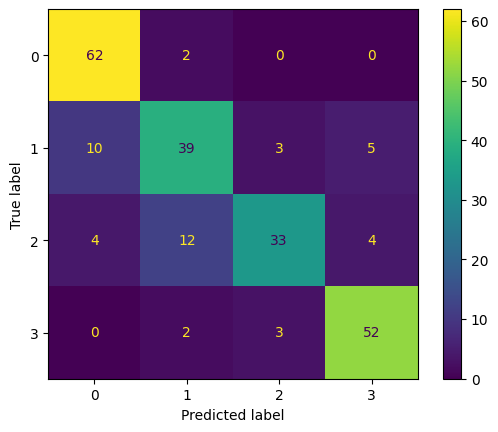

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def compute_metrics(labels, preds):
    
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    
    return {'accuracy': acc, 'precision':precision, 'recall':recall, 'f1':f1}

In [27]:
compute_metrics(y_test, y_pred_test)

{'accuracy': 0.8051948051948052,
 'precision': 0.8058733113306021,
 'recall': 0.7969706843760345,
 'f1': 0.7952225234235183}